In [1]:
import numpy as np
import cv2 as cv
import math
from matplotlib import pyplot as plt

### Exercise 1.1: Loading images

In [2]:
# Read the image file
img = cv.imread("../../Data/graffiti.png")

In [3]:
# COnvert to gray scale
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [4]:
# check the shape
print(f'Shape of Original image {img.shape} and GrayScale Image {gray_img.shape}')

Shape of Original image (640, 800, 3) and GrayScale Image (640, 800)


In [5]:
# init new array size
new_array = np.full((img.shape[0], img.shape[1]*2, img.shape[2]), 0)
new_array.shape

(640, 1600, 3)

In [6]:
# copy original image
new_array[0:img.shape[0], 0:img.shape[1], 0:img.shape[2]] = img

In [7]:
# copy gray scale image in all three chanel
for i in range(img.shape[2]):
    new_array[0:img.shape[0], img.shape[1]:new_array.shape[1], i] = gray_img

In [8]:
def cv2_imshow(title, img):

    cv.startWindowThread()
    cv.imshow(title, img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    return img

In [9]:
# Get the information of the incoming image type
info = np.iinfo(img.dtype) 

# normalize the data to 0 - 1
new_array = new_array.astype(np.float64) / info.max 

# Now scale by 255
new_array = 255 * new_array

# array to image
new_img = new_array.astype(np.uint8)

printed_img = cv2_imshow("new_image", new_img)

### Exercise 1.2: OpenCV experiments (2 Point)

In [10]:
cap = cv.VideoCapture(0)
mode = 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # wait for key and switch to mode
    ch = cv.waitKey(1) & 0xFF
    
    if ch == ord('1'):
        mode = 1
    elif ch == ord('2'):
        mode = 2
        
    elif ch == ord('3'):
        mode = 3
        
    elif ch == ord('4'):
        mode = 4
    
    elif ch == ord('5'):
        mode = 5
    elif ch == ord('6'):
        mode = 6
    elif ch == ord('q'):
        break

    
    if mode == 1:
        # Convert BGR to HSV
        frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    elif mode == 2:
        # Convert BGR to LAB
        frame = cv.cvtColor(frame, cv.COLOR_BGR2LAB)
    elif mode == 3:
        # Convert BGR to YUV
        frame = cv.cvtColor(frame, cv.COLOR_BGR2YUV)
    elif mode == 4:
        # Gaussian-Thresholding
        img = cv.medianBlur(frame, 5)
        
        # convert to gray scale
        gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        frame = cv.adaptiveThreshold(gray_img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    elif mode == 5:
        # Otsu's thresholding
        
        # convert to gray scale
        gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        ret, frame = cv.threshold(gray_img, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
        
    elif mode == 6:
        # Canny Edge Detection
        frame = cv.Canny(frame, 100, 200)

    # Display the resulting frame
    cv.imshow('frame', frame)

# When everything done, release the capture
cap.release()
cv.destroyAllWindows()

### Exercise 1.3: SIFT in OpenCV (1 Point)

In [11]:
cap = cv.VideoCapture(0)
cv.namedWindow('Learning from images: SIFT feature visualization')
while True:
    
    # 1. read each frame from the camera (if necessary resize the image)
    #    and extract the SIFT features using OpenCV methods
    #    Note: use the gray image - so you need to convert the image
    
    # Capture frame-by-frame
    ret, frame = cap.read()

    # wait for key and switch to mode
    ch = cv.waitKey(1) & 0xFF
    
    if ch == ord('q'):
        break
        
    # convert to gray scale
    gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    features = cv.SIFT_create()
    
    # 2. draw the keypoints using cv2.drawKeypoints
    #    There are several flags for visualization - e.g. DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
 
    keypoints = features.detect(gray_img, None)
 
    # drawKeypoints function is used to draw keypoints
    output_image = cv.drawKeypoints(gray_img, keypoints, 0, (255,0,0), \
                                    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    cv.imshow('frame', output_image)
    
        
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()

### Exercise 1.4: Convolution (2 Points)

In [12]:
def im2double(im):
    """
    Converts uint image (0-255) to double image (0.0-1.0) and generalizes
    this concept to any range.

    :param im:
    :return: normalized image
    """
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

In [13]:
def make_gaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    k = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return k / np.sum(k)

In [14]:
def convolution_2d(img, kernel):
    """
    Computes the convolution between kernel and image

    :param img: grayscale image
    :param kernel: convolution matrix - 3x3, or 5x5 matrix
    :return: result of the convolution
    """
    # TODO write convolution of arbritrary sized convolution here
    # Hint: you need the kernelsize

    offset = int(kernel.shape[0]/2)
    
    #print(f'Offset = {offset}')
    
    # Shape of the new image object
    new_shape = np.array(img.shape) + (np.array([offset, offset])*2)
    
    # define the enw array with offset size
    newimg = np.zeros(new_shape)
    
    # set the image to the new image array
    newimg[offset:img.shape[0]+offset, offset:img.shape[1]+offset] = img
    
    #print(newimg.shape, img.shape, kernel.shape)
    #print(offset-1, newimg.shape[0]-offset-1)
    
    #np.set_printoptions(precision=3)
    #print(newimg)
    
    new_img = np.zeros(img.shape)
    
    #print(img.shape, new_img.shape)
    
    for i in range(offset, newimg.shape[0]-offset):
        
        #if i==2:
            #break
        
        for j in range (offset, newimg.shape[1]-offset):
            
            #if j==2:
                #break
            #print(i, j)
            
            x_start = i-offset
            x_end = x_start+(2*offset)+1
            
            y_start = j-offset
            y_end = y_start+(2*offset)+1
            
            #print(i, x_start, x_end, y_start, y_end)
            
            temp_img = newimg[x_start:x_end, y_start:y_end]
            
            #print(temp_img.shape, kernel.shape)
            
            prod = temp_img * kernel
            
            #print((x_start, y_start), (x_end, y_end), temp_img.shape)
            
            #np.set_printoptions(precision=3)
            
            #print(kernel)
            
            #print(temp_img)
            
            #print(prod)
            
            sop = np.sum(prod)
            
            #print(sop)
            
            new_img[i-offset][j-offset] = sop
            
            #print(temp_img.shape, kernel.shape, prod.shape)

    #print(newimg == new_img)

    return new_img

#abc = convolution_2d(con_img, gk)

In [15]:
# Calculate the Magnitude of gradiant
def calculate_mog(gx, gy):
    
    gx2 = gx * gx # calculate gx^2
    
    gy2 = gy * gy # calculate gy^2
    
    return np.sqrt(gx2+gy2) # sqrt of gx^2 + gy^2

In [16]:
def draw_fig(gk_img, sobel_x_img, sobel_y_img, mog_img):
    fig = plt.figure(figsize=(10, 10))

    # draw gausian blur
    gk_image = fig.add_subplot(2,2,1)
    gk_image.set_title("Applied Gaussian Blur")
    gk_image.imshow(gk_img, cmap='gray')
    plt.axis('off')

    # draw sobel-X
    sobelx_image = fig.add_subplot(2,2,2)
    sobelx_image.set_title("Sobel-X output")
    sobelx_image.imshow(sobel_x_img, cmap='gray')
    plt.axis('off')

    # draw sobel-Y
    sobely_image = fig.add_subplot(2,2,3)
    sobely_image.set_title("Sobel-X output")
    sobely_image.imshow(sobel_y_img, cmap='gray')
    plt.axis('off')

    mog_image = fig.add_subplot(2,2,4)
    mog_image.imshow(mog_img, cmap='gray')
    mog_image.set_title("MOG output")
    plt.axis('off')
    
    plt.show()

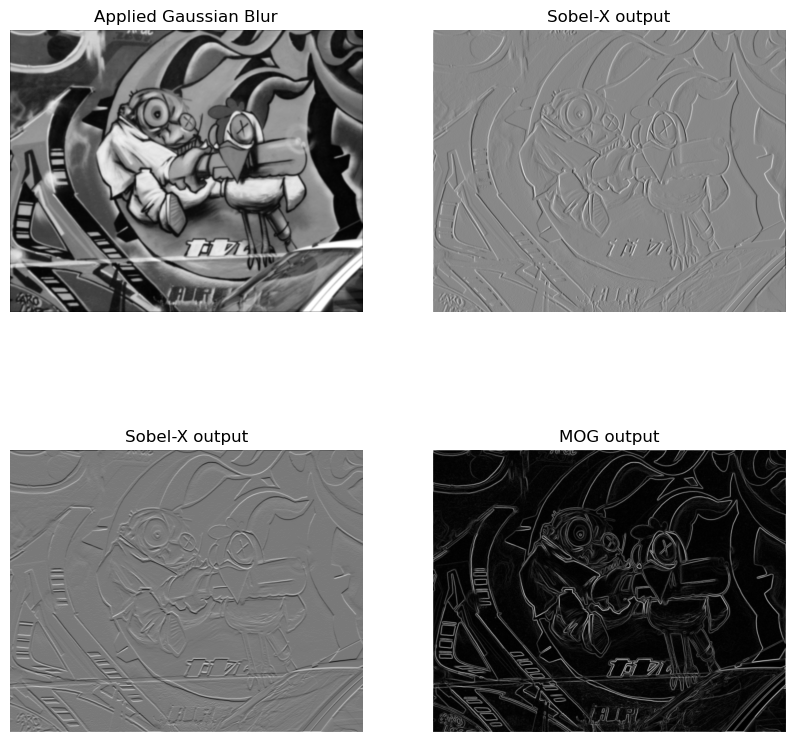

In [17]:
if __name__ == "__main__":

    # 1. load image in grayscale
    
    # Read the image file
    img = cv.imread("../../Data/graffiti.png")
    
    # COnvert to gray scale
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    
    # 2. convert image to 0-1 image (see im2double)
    con_img = im2double(gray_img)


    # image kernels
    sobelmask_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobelmask_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gk = make_gaussian(11)

    # 3 .use image kernels on normalized image
    sobel_x_img = convolution_2d(con_img, sobelmask_x)
    #new_image = cv2_imshow("sobel_x_iamge", sobel_x_img)
    
    sobel_y_img = convolution_2d(con_img, sobelmask_y)
    #new_image = cv2_imshow("sobel_y_iamge", sobel_y_img)
    
    gk_img = convolution_2d(con_img, gk)
    #new_image = cv2_imshow("gk_filter_output", gk_img)

    # 4. compute magnitude of gradients
    mog_img = calculate_mog(sobel_x_img, sobel_y_img)
    
    
    draw_fig(gk_img, sobel_x_img, sobel_y_img, mog_img)